<a href="https://colab.research.google.com/github/valerio-unifei/chemotherapy-safety/blob/main/RNCR_Volume_Seringas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

## Baixando imagens do Google Drive

In [ ]:
import gdown

# https://drive.google.com/file/d/1qWtEN-w19UUtfWChQkxzHSOyBLENXIQa/
syrDS = 'https://drive.google.com/uc?id=1qWtEN-w19UUtfWChQkxzHSOyBLENXIQa'
gdown.download(syrDS, 'SyringeDataset.zip', quiet=False)

!unzip -qq SyringeDataset.zip -d fullds
!rm SyringeDataset.zip



Downloading...
From: https://drive.google.com/uc?id=1qWtEN-w19UUtfWChQkxzHSOyBLENXIQa
To: /content/SyringeDataset.zip
100%|██████████| 269M/269M [00:02<00:00, 93.3MB/s]


Convertendo pastas com "ml" para apenas números (apenas para assegurar ordem das pastas)

In [ ]:
# para permitir de transforma classes em valores
import os
for i in range(21):
  os.rename(f'fullds/{i:02}ml', f'fullds/{i:02}')

## Importando Imagens das Pastas para o TensorFlow

É usando apenas 1 dataset aqui, onde as classes são inteiras (0 a 20) conforme nome das pastas

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

directory = '/content/fullds'

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
image_size = (128, 128)
batch_size = 32
cores = ['rgb', 'grayscale'][1]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=directory, 
    labels='inferred', 
    label_mode='int',
    class_names=None, 
    color_mode=cores, 
    batch_size=batch_size, 
    image_size=image_size, 
    shuffle=True, 
    seed=42, 
    validation_split=None, 
    subset=None,
    interpolation='bilinear', 
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 1233 files belonging to 21 classes.


Extraindo imagens para X e tutores (targets) para y

Os tutores são convertidos de inteiros (0 a 20) para reais (float) (0.0 a 20.0)

O batch é removido, os conjunto X e y são completos sem blocos.

In [ ]:
X = np.concatenate([x for x,y in train_ds],axis=0)
y = np.concatenate([y for x,y in train_ds],axis=0)
y = y.astype(float)
X.shape, y.shape

((1233, 128, 128, 1), (1233,))

# Rede Neural Convolucional Regressiva

A CNN regressiva apresenta apenas 1 saída do tipo float (real)

In [ ]:
channels = 3 if cores == 'rgb' else 1

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], channels)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1)) #regressao

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 50176)             0

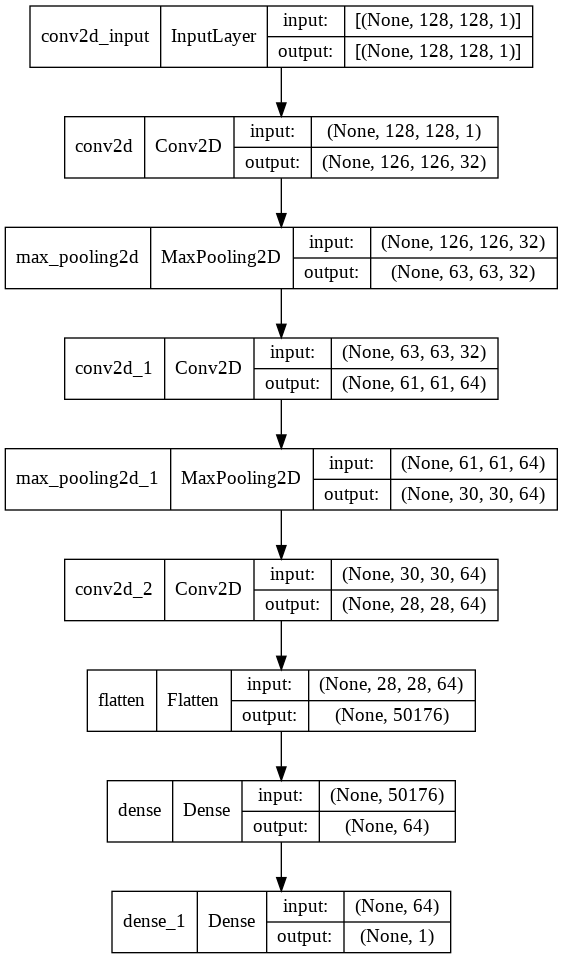

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(0.001),
    #optimizer = 'Adam',
    loss='mse',
    metrics=['mae', 'mse'],
    )

In [ ]:
model.predict(X)

array([[ 1.8343112],
       [19.80405  ],
       [11.800161 ],
       ...,
       [ 8.60848  ],
       [ 4.2254257],
       [ 6.5143948]], dtype=float32)

## Treinamento

Treinamento regressivo são utilizados MSE e MAE como critérios de avaliação.

RMSprop faz a otimização da rede regressiva

In [ ]:
tf.random.set_seed(42)

In [ ]:
history = model.fit(X, y, 
                    epochs=200, 
                    validation_split=0.2,
                    verbose=2)

Epoch 1/200
31/31 - 1s - loss: 0.8080 - mae: 0.6740 - mse: 0.8080 - val_loss: 46.5909 - val_mae: 5.7306 - val_mse: 46.5909 - 1s/epoch - 38ms/step
Epoch 2/200
31/31 - 1s - loss: 0.9644 - mae: 0.7197 - mse: 0.9644 - val_loss: 48.6637 - val_mae: 5.9784 - val_mse: 48.6637 - 1s/epoch - 34ms/step
Epoch 3/200
31/31 - 1s - loss: 0.8886 - mae: 0.7074 - mse: 0.8886 - val_loss: 46.9021 - val_mae: 5.8272 - val_mse: 46.9021 - 1s/epoch - 34ms/step
Epoch 4/200
31/31 - 1s - loss: 0.8566 - mae: 0.6735 - mse: 0.8566 - val_loss: 49.6168 - val_mae: 6.0356 - val_mse: 49.6168 - 1s/epoch - 36ms/step
Epoch 5/200
31/31 - 1s - loss: 2.1991 - mae: 0.9195 - mse: 2.1991 - val_loss: 47.3164 - val_mae: 5.8696 - val_mse: 47.3164 - 1s/epoch - 36ms/step
Epoch 6/200
31/31 - 1s - loss: 2.1498 - mae: 0.9138 - mse: 2.1498 - val_loss: 48.7844 - val_mae: 5.9809 - val_mse: 48.7844 - 1s/epoch - 34ms/step
Epoch 7/200
31/31 - 1s - loss: 0.8849 - mae: 0.6585 - mse: 0.8849 - val_loss: 47.4787 - val_mae: 5.8304 - val_mse: 47.4787 -

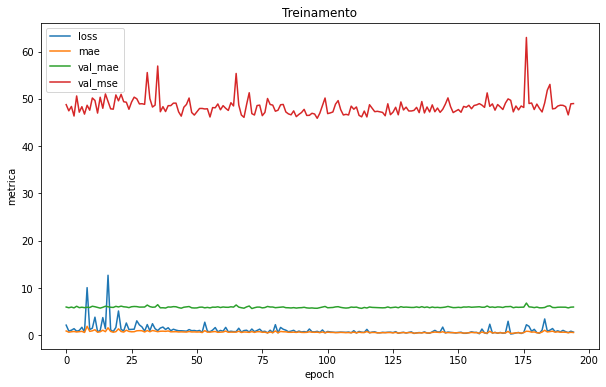

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
k = 5
plt.plot(history.history['loss'][k:])
plt.plot(history.history['mae'][k:])
plt.plot(history.history['val_mae'][k:])
plt.plot(history.history['val_mse'][k:])
plt.title('Treinamento')
plt.ylabel('metrica')
plt.xlabel('epoch')
plt.legend(['loss', 'mae','val_mae','val_mse'], loc='upper left')

In [ ]:
import pandas as pd
pd.DataFrame(history.history).describe()

,loss,mae,mse,val_loss,val_mae,val_mse
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1.120493,0.687550,1.120493,48.353841,5.938720,48.353841
std,1.241735,0.183449,1.241735,1.856255,0.135930,1.856255
min,0.281942,0.391002,0.281942,45.893211,5.658524,45.893208
25%,0.622123,0.571352,0.622123,47.252058,5.849362,47.252058
50%,0.814007,0.660030,0.814007,48.195215,5.934487,48.195215
75%,1.158025,0.758739,1.158025,48.886730,5.993105,48.886730
max,12.700800,1.903701,12.700800,62.991203,6.818378,62.991203


# Testes dos Resultados

In [ ]:
y_pred = model.predict(X)
y_pred = [u[0] for u in y_pred]
resultados = pd.DataFrame([y, y_pred], index=['Tutor','Previsto']).T
resultados.to_csv('Resultados.csv')
resultados

,Tutor,Previsto
0,2.0,2.142053
1,17.0,17.047573
2,12.0,11.693392
3,19.0,18.216654
4,6.0,5.949987
...,...,...
1228,7.0,9.119993
1229,19.0,13.122164
1230,14.0,7.816648
1231,6.0,6.909886


In [ ]:
resultados['Previsto'] = resultados['Previsto'].astype(int)

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = resultados['Tutor'].values
y_pred = resultados['Previsto'].values

mc = confusion_matrix(y_true, y_pred)
mc

array([[ 8,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0],
       [45,  5,  0,  0,  0,  3,  2,  0,  1,  2,  3,  1,  1,  2,  1,  1,
         0,  0,  0,  0,  0,  0],
       [ 0, 25, 18,  1,  0,  0,  1,  1,  2,  0,  1,  1,  1,  0,  2,  0,
         0,  0,  0,  0,  0,  0],
       [ 0,  1, 17,  4,  0,  1,  0,  1,  0,  0,  1,  1,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 14, 11,  0,  1,  0,  1,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 15,  9,  0,  0,  1,  1,  1,  0,  0,  1,  2,  0,
         0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 57, 28,  1,  1,  4,  1,  3,  1,  0,  0,  0,
         0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 14,  8,  2,  2,  0,  1,  1,  2,  1,  0,
         0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 16,  6,  3,  0,  0,  1,  0,  0,  0,
         0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  1,  1, 50, 13,  1,  1,

In [ ]:
import seaborn as sn
dfmc = pd.DataFrame(data = confusion_matrix(y_true, y_pred))
dfmc.to_latex('MatrizConfu.tex')
sn.heatmap(dfmc, annot=True, cmap="YlGnBu")

NameError: ignored

In [ ]:
model.save('seringa_regre.h5')